In [15]:
import numpy as np
import torch 
import pandas as pd
import pickle
import time
import sys
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from tueplots import axes, bundles
plt.rcParams.update({"figure.dpi": 150})

plt.rcParams.update(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
)

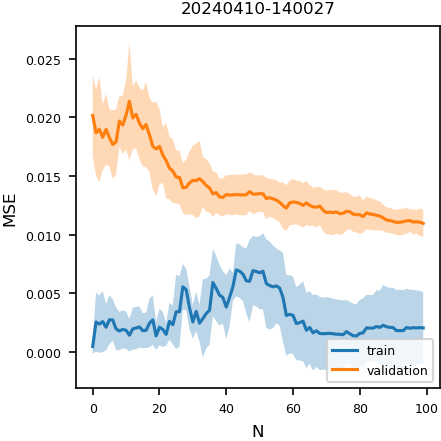

In [16]:
#plotting a learning curve
timestamp = "20240410-140027"
base_path = f"./output/{timestamp}"
seeds = [0,1,2,3,4]
trait = "narea"

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(3,3))

    def getCol(col_name):
        _results = [pd.read_csv(f"{base_path}/gp_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
        _results = [np.array(_results[i]) for i in range(0,len(_results))]
        return _results

    n = getCol("n")[0]
    train_loss = getCol("train_loss")
    val_loss = getCol("val_loss")

    def linePlot(ax, _results, label):
        mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
        ax.plot(n, mean, label=label)
        ax.fill_between(n, mean - var,  mean + var, alpha=0.3)
        return

    linePlot(ax, train_loss, label="train")
    linePlot(ax, val_loss, label="validation")

    ax = ax
    ax.set_title(f"{timestamp}") 
    ax.set_xlabel("N") 
    ax.set_ylabel("MSE")
    ax.legend(loc="lower right")
    plt.show()